<a href="https://www.kaggle.com/code/abdelmoneimrehab/baseline-models-use-pretrained-model?scriptVersionId=198703740" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <a id='step1'></a>
# <div style="background-color:#012622;background-size: cover;font-family:tahoma;font-size:200%;text-align:center;border-radius:25px 25px 25px 25px; padding:10px; border:solid 2px #09375b"><span style="color:red"><b><b></span><span style="color:white"><b>NLP With Disaster Tweets</b></span></div>

## <a id='step1'></a>
# <span style="font-family:Tahoma, sans-serif; font-size:110%; text-align:left;">
# <span style="color:#FF6347;"><b>Step 1 |</b></span>
# <span style="color:#2E8B57;"><b> import important libraries</b></span>
# </span>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import Counter
import re
from nltk.tokenize import word_tokenize
import gensim
import string
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Input, Dropout, Embedding
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical, pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [2]:
! wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


--2024-09-28 21:07:51--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: 'helper_functions.py.3'

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2024-09-28 21:07:51 (16.5 MB/s) - 'helper_functions.py.3' saved [10246/10246]



## <a id='step2'></a>
# <span style="font-family:Tahoma, sans-serif; font-size:110%; text-align:left;">
# <span style="color:#FF6347;"><b>Step 2 |</b></span>
# <span style="color:#2E8B57;"><b> Check GPU</b></span>
# </span>


In [3]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-52db8cd6-0e29-5d03-f395-ffffa09f81df)
GPU 1: Tesla T4 (UUID: GPU-b97cfb9f-07e8-c145-ad29-8505a1078eef)


## <a id='step3'></a>
# <span style="font-family:Tahoma, sans-serif; font-size:110%; text-align:left;">
# <span style="color:#FF6347;"><b>Step 3 |</b></span>
# <span style="color:#2E8B57;"><b> Download text Data</b></span>
# </span>


In [4]:
# Download data (same as from Kaggle)
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"

# Unzip data
unzip_data("nlp_getting_started.zip")

--2024-09-28 21:07:53--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.197.207, 108.177.98.207, 74.125.142.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.197.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: 'nlp_getting_started.zip.3'

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.007s  

2024-09-28 21:07:53 (84.4 MB/s) - 'nlp_getting_started.zip.3' saved [607343/607343]



In [5]:
train_df = pd.read_csv("/kaggle/working/train.csv")
test_df = pd.read_csv("/kaggle/working/test.csv")
sample_sub = pd.read_csv("/kaggle/working/sample_submission.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
# shuffle data
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [7]:
# visualize text data
train_df_shuffled.target.value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

In [8]:
random_index = np.random.randint(0, len(train_df_shuffled)-5)
for _, row in train_df_shuffled[['text', 'target']][random_index: random_index + 5].iterrows():
  text = row['text']
  target = row['target']
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 0 (not real disaster)
Text:
Day 2. Liquidation of emergency at chemical object. #USAR2015 #USAR15 #RUOR #??????????? http://t.co/gGTmDqUdDo

---

Target: 0 (not real disaster)
Text:
If I survive tonight. I wouldn't change one thing. ??

---

Target: 0 (not real disaster)
Text:
Homeless Man Traveling Across USA With 11 Stray Dogs He Rescued Gets A Helping Hand From Strangers http://t.co/QhfqlUI6RY via @Reshareworthy

---

Target: 0 (not real disaster)
Text:
He better than Sean bro. I can admit that Sean is flames now. But he better than Sean https://t.co/aomQ1RYKmJ

---

Target: 0 (not real disaster)
Text:
#veterans VET Act would ensure every military veteran's access to highest level of emergency care services: Proper treatmen...  #followme

---



## <a id='step4'></a>
# <span style="font-family:Tahoma, sans-serif; font-size:110%; text-align:left;">
# <span style="color:#FF6347;"><b>Step 4 |</b></span>
# <span style="color:#2E8B57;"><b> Data Visualization</b></span>
# </span>


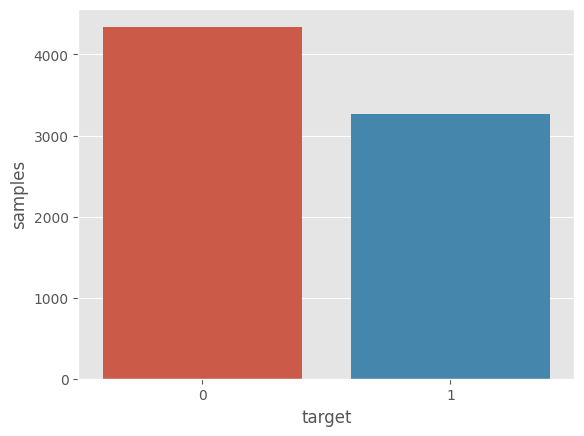

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming train_df is your DataFrame, and 'target' is the column
x = train_df['target'].value_counts()

# Use keyword arguments 'x' and 'y'
sns.barplot(x=x.index, y=x)

# Set the y-axis label
plt.gca().set_ylabel('samples')

# Show the plot
plt.show()

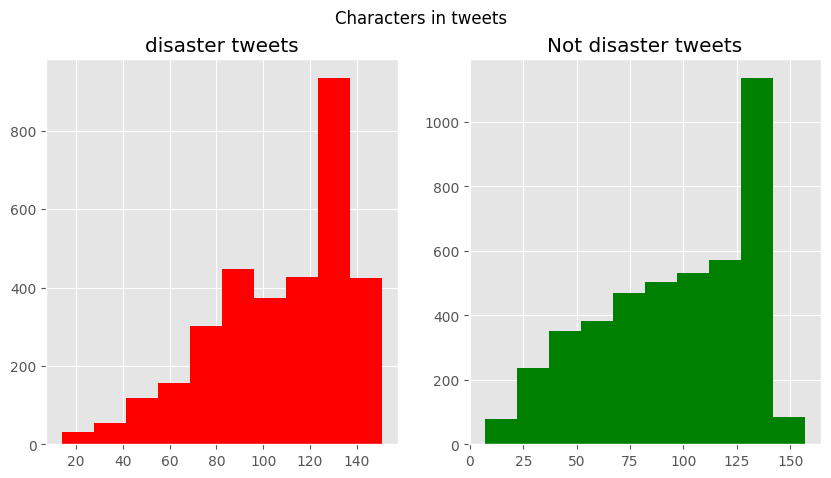

In [10]:
# Number of charcters in tweets
fig,(ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
tweet_len = train_df[train_df['target'] == 1]['text'].str.len()
ax1.hist(tweet_len,color = 'red')
ax1.set_title('disaster tweets')
tweet_len = train_df[train_df['target'] == 0]['text'].str.len()
ax2.hist(tweet_len,color = 'green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()

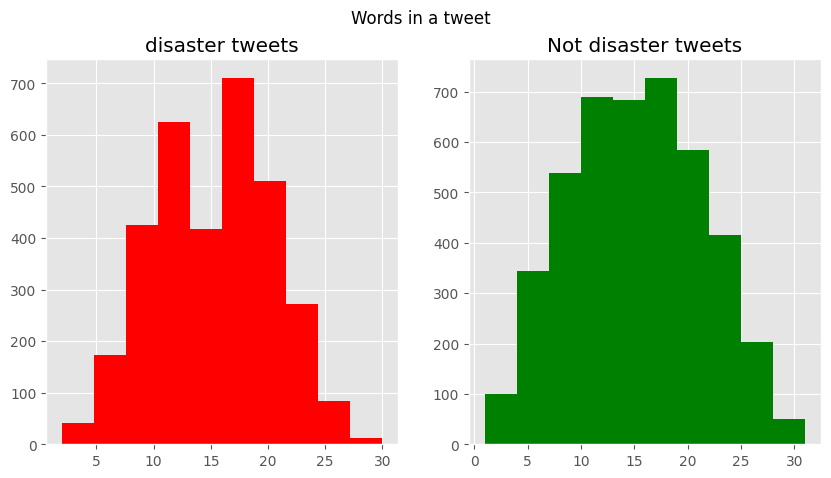

In [11]:
# Number of words in tweet
fig,(ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
tweet_len = train_df[train_df['target'] == 1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len, color = 'red')
ax1.set_title('disaster tweets')
tweet_len = train_df[train_df['target'] == 0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len, color = 'green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

In [12]:
def create_corpus(target):
    corpus = []
    for x in train_df[train_df['target'] == target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

<BarContainer object of 10 artists>

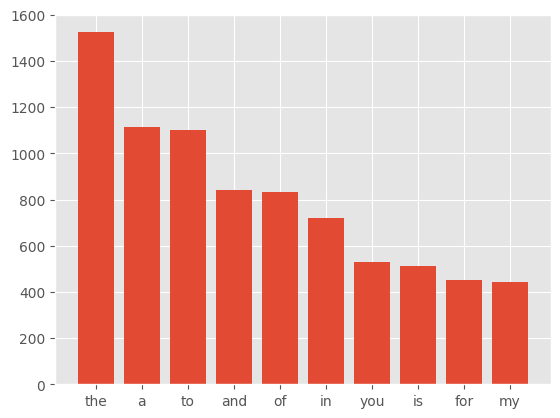

In [13]:
# common stopwords in tweets in class 0
corpus = create_corpus(0)

dic = defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word] += 1
top = sorted(dic.items(), key = lambda x: x[1], reverse = True)[:10]
x, y = zip(*top)
plt.bar(x, y)

<BarContainer object of 10 artists>

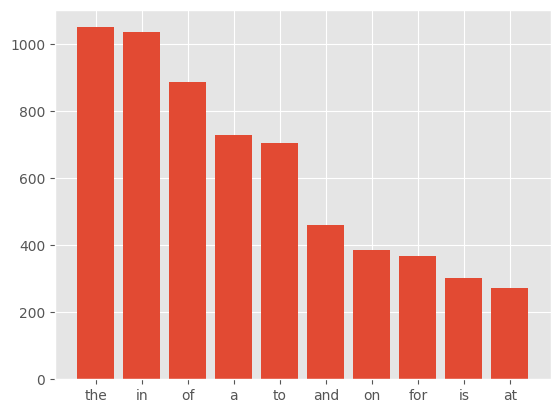

In [14]:
# common stopwords in tweets in class 1
corpus = create_corpus(1)

dic = defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word] += 1
top = sorted(dic.items(), key = lambda x: x[1], reverse = True)[:10]
x, y = zip(*top)
plt.bar(x, y)

<BarContainer object of 18 artists>

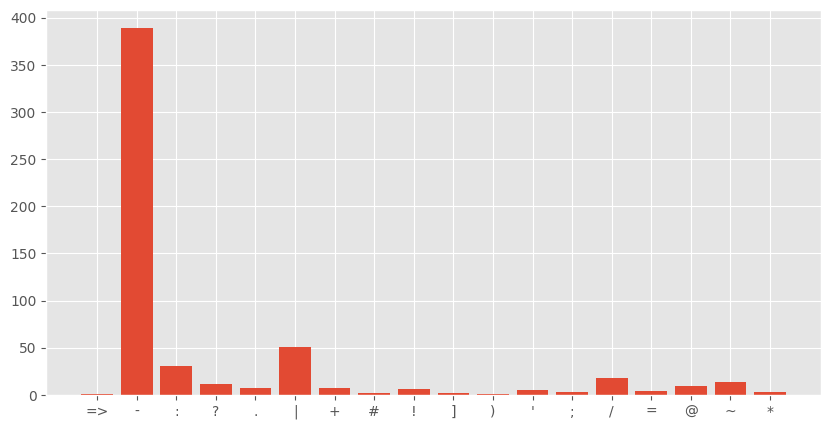

In [15]:
# Analyzing Punctuations in class 1
plt.figure(figsize = (10, 5 ))
corpus = create_corpus(1)

dic = defaultdict(int)
special = string.punctuation
for i in corpus:
    if i in special:
        dic[i] += 1
x, y = zip(*dic.items())
plt.bar(x, y)

<BarContainer object of 20 artists>

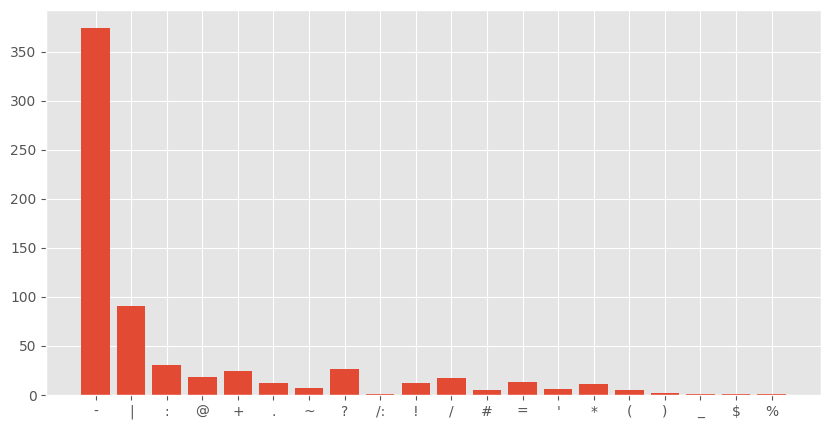

In [16]:
# Analyzing Punctuations in class 0
plt.figure(figsize = (10, 5 ))
corpus = create_corpus(0)

dic = defaultdict(int)
special = string.punctuation
for i in corpus:
    if i in special:
        dic[i] += 1
x, y = zip(*dic.items())
plt.bar(x, y)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


<Axes: >

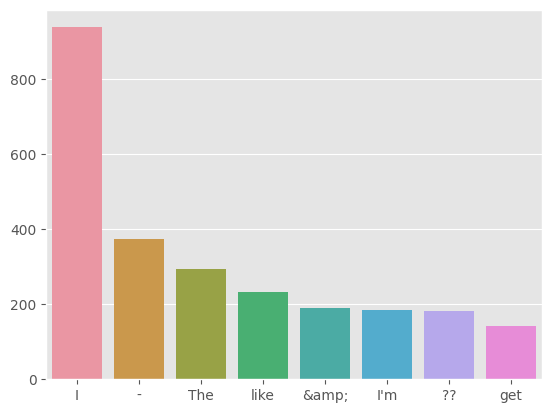

In [17]:
# common words
counter = Counter(corpus)
most = counter.most_common()
x = []
y = []
for word, count in most[:40]:
    if (word not in stop):
        x.append(word)
        y.append(count)
sns.barplot(x = x, y = y)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


<Axes: >

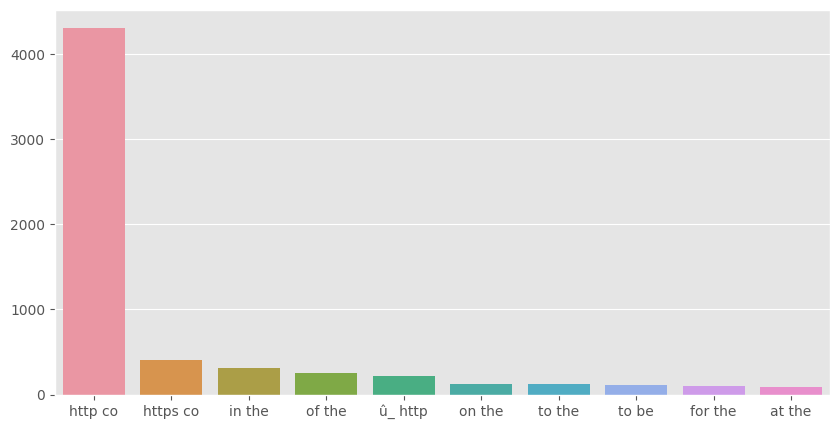

In [18]:
# n_gram analysis
def get_top_tweet_bigrams(corpus, n = None):
    vec = CountVectorizer(ngram_range = (2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis = 0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
plt.figure(figsize = (10, 5))
top_tweet_bigrams = get_top_tweet_bigrams(train_df['text'])[:10]
x, y = map(list, zip(*top_tweet_bigrams))
sns.barplot(x = x, y = y)

## <a id='step5'></a>
# <span style="font-family:Tahoma, sans-serif; font-size:110%; text-align:left;">
# <span style="color:#FF6347;"><b>Step 5 |</b></span>
# <span style="color:#2E8B57;"><b> Data Cleaning</b></span>
# </span>


### we will do some basic cleaning such as spelling correction,removing punctuations,removing html tags and emojis etc.So let's start.

In [19]:
df = pd.concat([train_df, test_df])
df.shape

(10876, 5)

In [20]:
# removing urls
example="New competition launched :https://www.kaggle.com/c/nlp-getting-started"

def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)
remove_url(example)

'New competition launched :'

In [21]:
df['text'] = df['text'].apply(lambda x: remove_url(x))

In [22]:
# removing html tags
example = """<div>
<h1>Real or Fake</h1>
<p>Kaggle </p>
<a href="https://www.kaggle.com/c/nlp-getting-started">getting started</a>
</div>"""

def remove_html(text):
    html_tag = re.compile(r'<.*?>')
    return html_tag.sub(r'', text)
remove_html(example)

'\nReal or Fake\nKaggle \ngetting started\n'

In [23]:
df['text'] = df['text'].apply(lambda x: remove_html(x))

In [24]:
# removing emojis

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

remove_emoji("Omg another Earthquake 😔😔")

'Omg another Earthquake '

In [25]:
df['text'] = df['text'].apply(lambda x: remove_emoji(x))

In [26]:
# removing punctuations
def remove_punct(text):
    table = str.maketrans('','',string.punctuation)
    return text.translate(table)

example = "I am a #king?"
print(remove_punct(example))

I am a king


In [27]:
df['text'] = df['text'].apply(lambda x: remove_punct(x))

## <a id='step6'></a>
# <span style="font-family:Tahoma, sans-serif; font-size:110%; text-align:left;">
# <span style="color:#FF6347;"><b>Step 6 |</b></span>
# <span style="color:#2E8B57;"><b> split data into train and validation sets</b></span>
# </span>


In [28]:
train = df[:train_df.shape[0]]
test = df[train_df.shape[0]:]
train_df_shuffled = train.sample(frac=1, random_state=42)
train_df_shuffled.shape

(7613, 5)

In [29]:
from sklearn.model_selection import train_test_split
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled['text'].to_numpy(),
                                                                            train_df_shuffled['target'].to_numpy(),
                                                                            test_size = 0.1,
                                                                            random_state = 42)
train_sentences.shape, val_sentences.shape, train_labels.shape, val_labels.shape

((6851,), (762,), (6851,), (762,))

In [30]:
train_sentences

array(['mogacola zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       'Gurmeetramrahim MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai',
       ..., 'Near them on the sand half sunk a shattered visage lies ',
       'kesabaran membuahkan hasil indah pada saat tepat life isnt about waiting for the storm to pass its about learning to dance in the rain',
       'ScottDPierce billharristv HarrisGle Beezersun Im forfeiting this years fantasy football pool out of fear I may win n get my ass kicked'],
      dtype=object)

## <a id='tokens'></a>
# <span style="font-family:Tahoma, sans-serif; font-size:110%; text-align:left;">
# <span style="color:#FF6347;"><b></b></span>
# <span style="color:#2E8B57;"><b> Tokenization and Embedding Approaches</b></span>
# </span>


**Manual Tokenization and Embedding using GloVe:**

    Tokenize the text manually.
    Use GloVe embeddings for converting tokens into vectors.

**Automated Tokenization and Embedding using TextVectorization:**

    Utilize the TextVectorization layer to tokenize and generate embeddings automatically.


In [34]:
# Tokenize the text manually.
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_sentences)
word2index = tokenizer.word_index

train_Xtokens = tokenizer.texts_to_sequences(train_sentences)
test_Xtokens = tokenizer.texts_to_sequences(val_sentences)

def get_maxlen(data):
    maxlen = 0
    for sent in data:
        maxlen = max(maxlen, len(sent))
    return maxlen

train_Xmaxlen = get_maxlen(train_Xtokens)
test_Xmaxlen = get_maxlen(test_Xtokens)

Xtrain = pad_sequences(train_Xtokens, maxlen = train_Xmaxlen,  padding = 'post', truncating = 'post')
Xtest = pad_sequences(test_Xtokens, maxlen = test_Xmaxlen,  padding = 'post', truncating = 'post')

train_Xmaxlen, test_Xmaxlen

(31, 30)

In [36]:
# Use GloVe embeddings for converting tokens into vectors.
!wget http://nlp.stanford.edu/data/glove.twitter.27B.zip

# unzip in my drive
unzip_data('glove.twitter.27B.zip')


--2024-09-28 16:35:27--  http://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.twitter.27B.zip [following]
--2024-09-28 16:35:27--  https://nlp.stanford.edu/data/glove.twitter.27B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip [following]
--2024-09-28 16:35:27--  https://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [ap

In [37]:
file = open('/kaggle/working/glove.twitter.27B.200d.txt', 'r', encoding = 'utf8')
content = file.readlines()
file.close()

embeddings = {}

for line in content:
    line = line.split()
    embeddings[line[0]] = np.array(line[1:], dtype = float)

embed_size = 200
embedding_matrix = np.zeros((len(word2index)+1, embed_size))

for word, i in word2index.items():
    embed_vector = embeddings.get(word) # Use get() to avoid KeyError
    if embed_vector is not None:
        embedding_matrix[i] = embed_vector
    else:
        embedding_matrix[i] = np.random.randn(embed_size) # Replace OOV with random vector

In [38]:
embedding_matrix.shape

(16947, 200)

## Automated Tokenization and Embedding using TextVectorization

In [39]:
# text vectorization
max_len = round(sum([len(i.split()) for i in train_sentences]) / len(train_sentences))
text_vectorizer = TextVectorization(max_tokens = 10000,
                                    standardize = 'lower_and_strip_punctuation',
                                    split = 'whitespace',
                                    ngrams = None,
                                    output_mode = 'int',
                                    output_sequence_length = max_len)
text_vectorizer.adapt(train_sentences)

In [40]:
# create an embedding using an embedding layer
tf.random.set_seed(42)

embedding = Embedding(input_dim = 10000,
                      output_dim = 128,
                      embeddings_initializer = 'uniform',
                      input_length = max_len,
                      name = 'embedding_1')
embedding

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


<Embedding name=embedding_1, built=False>

In [41]:
# Get a random sentence from training set
import random
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nEmbedded version:")

# Embed the random sentence
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
Death threats on a nigga life well then we gon see      

Embedded version:


<tf.Tensor: shape=(1, 14, 128), dtype=float32, numpy=
array([[[-0.01257417,  0.03811056,  0.04110955, ..., -0.02314791,
          0.0381796 ,  0.03316   ],
        [-0.01781263, -0.04852973, -0.02902364, ..., -0.03169535,
         -0.00670584,  0.04057098],
        [ 0.02699416,  0.04747528,  0.04643948, ...,  0.00767759,
          0.00944318, -0.04902251],
        ...,
        [-0.0308162 , -0.01297183,  0.00863887, ..., -0.04767881,
          0.04829783,  0.03708316],
        [-0.0308162 , -0.01297183,  0.00863887, ..., -0.04767881,
          0.04829783,  0.03708316],
        [-0.0308162 , -0.01297183,  0.00863887, ..., -0.04767881,
          0.04829783,  0.03708316]]], dtype=float32)>

## <a id='step7'></a>
# <span style="font-family:Tahoma, sans-serif; font-size:110%; text-align:left;">
# <span style="color:#FF6347;"><b>Step 7 |</b></span>
# <span style="color:#2E8B57;"><b> Modelling</b></span>
# </span>


## <a id='step61'></a>
# <span style="font-family:Tahoma, sans-serif; font-size:110%; text-align:left;">
# <span style="color:#FF6347;"><b>Step 6.1 |</b></span>
# <span style="color:#2E8B57;"><b> Model_0: Getting a baseline (MultinomialNB)</b></span>
# </span>


In [42]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

# Fit the pipeline on the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [43]:
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.92%


In [44]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.])

## Evaluation of baseline model

In [45]:
from helper_functions import calculate_results
baseline_results = calculate_results(y_true = val_labels,
                                     y_pred = baseline_preds)
baseline_results

{'accuracy': 79.92125984251969,
 'precision': 0.8170352358459949,
 'recall': 0.7992125984251969,
 'f1': 0.7932860541527299}

## <a id='step62'></a>
# <span style="font-family:Tahoma, sans-serif; font-size:110%; text-align:left;">
# <span style="color:#FF6347;"><b>Step 6.2 |</b></span>
# <span style="color:#2E8B57;"><b>Model_1: A simple Dense Model (using Embedding layer)</b></span>
# </span>


In [46]:
import tensorflow as tf
from tensorflow.keras import layers

# Create a tensorboard callback (need to create a new one for each model)
tf.random.set_seed(42)

# create a directory to save tensorboard logs
save_dir = 'model_logs'

model_1 = Sequential([
    Input(shape = (1,), dtype = tf.string),
    text_vectorizer,
    embedding,
    layers.GlobalAveragePooling1D(),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
], name = 'model_1_dense')

model_1.compile(loss = 'binary_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

model_1.summary()

Model: "model_1_dense"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 14)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 14, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,304,833 (4.98 MB)

 Trainable params: 1,304,833 (4.98 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
history_1 = model_1.fit(train_sentences,
                        train_labels,
                        epochs = 5,
                        validation_data = (val_sentences, val_labels),
                        callbacks = [create_tensorboard_callback(dir_name = save_dir,
                                                                 experiment_name = 'model_1_dense')])

Saving TensorBoard log files to: model_logs/model_1_dense/20240928-164259
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6615 - loss: 0.6030 - val_accuracy: 0.7717 - val_loss: 0.4749
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8573 - loss: 0.3479 - val_accuracy: 0.7572 - val_loss: 0.5155
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9069 - loss: 0.2395 - val_accuracy: 0.7703 - val_loss: 0.6229
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9339 - loss: 0.1698 - val_accuracy: 0.7677 - val_loss: 0.7258
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9503 - loss: 0.1259 - val_accuracy: 0.7651 - val_loss: 0.8422


In [48]:
model_1_pred_probs = model_1.predict(val_sentences)
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs)) # squeeze removes single dimensions
model_1_preds[:20]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [49]:
# Calculate model_1 metrics
model_1_results = calculate_results(y_true = val_labels,
                                    y_pred = model_1_preds)
model_1_results

{'accuracy': 76.50918635170603,
 'precision': 0.7651942436766878,
 'recall': 0.7650918635170604,
 'f1': 0.7638552992897211}

## <a id='step62'></a>
# <span style="font-family:Tahoma, sans-serif; font-size:110%; text-align:left;">
# <span style="color:#FF6347;"><b></b></span>
# <span style="color:#2E8B57;"><b>Using the same model but with (GloVe embeddings)</b></span>
# </span>


In [50]:
tf.random.set_seed(42)
model_1_glove = Sequential([
              Input(shape = (1,)),
              Embedding(input_dim = len(word2index) + 1,
              output_dim = embed_size,
              input_length = train_Xmaxlen,
              weights = [embedding_matrix],
              trainable = False
             ),
    layers.GlobalAveragePooling1D(),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])

model_1_glove.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model_1_glove.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 1, 200)         │     3,389,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 200)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        25,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,423,449 (13.06 MB)

 Trainable params: 34,049 (133.00 KB)

 Non-trainable params: 3,389,400 (12.93 MB)

In [51]:
history_2 = model_1_glove.fit(Xtrain,
                        train_labels,
                        epochs = 5,
                        validation_data = (Xtest, val_labels),
                        callbacks = [create_tensorboard_callback(dir_name = save_dir,
                                                                 experiment_name = 'model_1_dense_glove')])

Saving TensorBoard log files to: model_logs/model_1_dense_glove/20240928-164325
Epoch 1/5


I0000 00:00:1727541806.391860     210 service.cc:145] XLA service 0x79100414b140 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727541806.391914     210 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1727541806.391918     210 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 75/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6531 - loss: 0.6414

I0000 00:00:1727541807.287487     210 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7143 - loss: 0.5763 - val_accuracy: 0.7756 - val_loss: 0.4693
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7912 - loss: 0.4557 - val_accuracy: 0.7848 - val_loss: 0.4524
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8003 - loss: 0.4362 - val_accuracy: 0.7848 - val_loss: 0.4438
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8117 - loss: 0.4155 - val_accuracy: 0.7874 - val_loss: 0.4424
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8243 - loss: 0.3934 - val_accuracy: 0.7874 - val_loss: 0.4401


In [52]:
model_1_glove_pred_probs = model_1_glove.predict(Xtest)
model_1_glove_preds = tf.squeeze(tf.round(model_1_glove_pred_probs))
model_1_glove_results = calculate_results(y_true = val_labels,
                                    y_pred = model_1_glove_preds)
model_1_glove_results

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


{'accuracy': 78.74015748031496,
 'precision': 0.7884607344435928,
 'recall': 0.7874015748031497,
 'f1': 0.785927114130143}

In [ ]:
!tensorboard dev upload --logdir ./model_logs \
  --name "First deep model on text data" \
  --description "Trying a dense model with an embedding layer and with an Glove embedding" \
  --one_shot # exits the uploader when upload has finished

2024-09-10 14:53:57.413160: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered

2024-09-10 14:53:57.443286: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered

2024-09-10 14:53:57.451149: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered

2024-09-10 14:53:59.092520: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


ERROR: The `tensorboard dev` command is no longer available.



TensorBoard.dev has been shut down. For further information,

see the FAQ at <https://tensorboard.dev/>.



In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir model_logs

![](https://github.com/Xmen3em/Beginner-Projects/blob/main/Beginner-NLP-%20Projects/Natural%20Language%20Processing%20with%20Disaster%20Tweets/Screenshot%202024-09-10%20062208.png?raw=true)

## <a id='step63'></a>
# <span style="font-family:Tahoma, sans-serif; font-size:110%; text-align:left;">
# <span style="color:#FF6347;"><b>Step 6.3 |</b></span>
# <span style="color:#2E8B57;"><b>Model 2: LSTM</b></span>
# </span>


In [54]:
tf.random.set_seed(42)
from tensorflow.keras import layers

model_2_embedding = Embedding(input_dim = 10000,
                      output_dim = 128,
                      embeddings_initializer = 'uniform',
                      input_length = max_len,
                      name = 'embedding_2')
model_2 = Sequential([
    Input(shape = (1,), dtype = tf.string),
    text_vectorizer,
    model_2_embedding,
    layers.SpatialDropout1D(0.2),
    layers.LSTM(64, dropout = 0.2, recurrent_dropout = 0.2, return_sequences = True) ,
    layers.LSTM(64, dropout = 0.2, recurrent_dropout = 0.2),
    Dense(128, activation = 'relu'),
    layers.Dropout(0.5),
    Dense(64, activation = 'relu'),
    layers.BatchNormalization(),
    Dense(1, activation = 'sigmoid')
], name = 'model_2_LSTM')

model_2.compile(loss = 'binary_crossentropy',
                optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics = ['accuracy'])

model_2.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "model_2_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 14)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 14, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 14, 128)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 14, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,379,329 (5.26 MB)

 Trainable params: 1,379,201 (5.26 MB)

 Non-trainable params: 128 (512.00 B)

In [55]:
# Fit model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(save_dir,
                                                                     "LSTM")])

Saving TensorBoard log files to: model_logs/LSTM/20240928-164609
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.5334 - loss: 0.6897 - val_accuracy: 0.5433 - val_loss: 0.6839
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.6720 - loss: 0.6144 - val_accuracy: 0.7546 - val_loss: 0.5825
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.7753 - loss: 0.4794 - val_accuracy: 0.7756 - val_loss: 0.4816
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.8252 - loss: 0.4089 - val_accuracy: 0.7782 - val_loss: 0.4670
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.8576 - loss: 0.3516 - val_accuracy: 0.7730 - val_loss: 0.5065


In [56]:
model_2_pred_probs = model_2.predict(val_sentences)
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_results = calculate_results(y_true = val_labels,
                                    y_pred = model_2_preds)
model_2_results

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


{'accuracy': 77.29658792650919,
 'precision': 0.7831409653233594,
 'recall': 0.7729658792650919,
 'f1': 0.767742217877152}

## <a id='step63'></a>
# <span style="font-family:Tahoma, sans-serif; font-size:110%; text-align:left;">
# <span style="color:#FF6347;"><b></b></span>
# <span style="color:#2E8B57;"><b>Model 2: LSTM with GLOVE Embedding</b></span>
# </span>


In [59]:
tf.random.set_seed(42)
model_2_glove = Sequential([
              Input(shape = (1,)),
              Embedding(input_dim = len(word2index) + 1,
              output_dim = embed_size,
              input_length = train_Xmaxlen,
              weights = [embedding_matrix],
              trainable = False
             ),
    layers.SpatialDropout1D(0.2),
    layers.LSTM(64, dropout = 0.2, recurrent_dropout = 0.2, return_sequences = True) ,
    layers.LSTM(64, dropout = 0.2, recurrent_dropout = 0.2, return_sequences = True),
    layers.LSTM(64),
    Dense(256, activation = 'relu'),
    layers.Dropout(0.5),
    Dense(128, activation = 'relu'),
    layers.BatchNormalization(),
    Dense(1, activation = 'sigmoid')
])

model_2_glove.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model_2_glove.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 1, 200)         │     3,389,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_2             │ (None, 1, 200)         │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 1, 64)          │        67,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 1, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,573,465 (13.63 MB)

 Trainable params: 183,809 (718.00 KB)

 Non-trainable params: 3,389,656 (12.93 MB)

In [60]:
history_3 = model_2_glove.fit(Xtrain,
                        train_labels,
                        epochs = 10,
                        validation_data = (Xtest, val_labels),
                        callbacks = [create_tensorboard_callback(dir_name = save_dir,
                                                                 experiment_name = 'model_2_LSTM_glove')])

Saving TensorBoard log files to: model_logs/model_2_LSTM_glove/20240928-165025
Epoch 1/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 21s 77ms/step - accuracy: 0.6365 - loss: 0.6380 - val_accuracy: 0.7835 - val_loss: 0.5234
Epoch 2/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 16s 72ms/step - accuracy: 0.7694 - loss: 0.5009 - val_accuracy: 0.7690 - val_loss: 0.4878
Epoch 3/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 16s 74ms/step - accuracy: 0.7839 - loss: 0.4742 - val_accuracy: 0.7690 - val_loss: 0.5381
Epoch 4/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 16s 73ms/step - accuracy: 0.7960 - loss: 0.4566 - val_accuracy: 0.7677 - val_loss: 0.4748
Epoch 5/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 16s 75ms/step - accuracy: 0.7999 - loss: 0.4505 - val_accuracy: 0.7795 - val_loss: 0.4854
Epoch 6/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 16s 74ms/step - accuracy: 0.7991 - loss: 0.4386 - val_accuracy: 0.7690 - val_loss: 0.5121
Epoch 7/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 16s 74ms/step - accuracy: 0.7971 - loss: 0.4413 - val_accuracy: 0.7940 - val_loss: 0.4762
Epoch 8/10


In [61]:
model_2_glove_pred_probs = model_2_glove.predict(Xtest)
model_2_glove_preds = tf.squeeze(tf.round(model_2_glove_pred_probs))
model_2_glove_results = calculate_results(y_true = val_labels,
                                    y_pred = model_2_glove_preds)
model_2_glove_results

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


{'accuracy': 78.4776902887139,
 'precision': 0.7850053249995637,
 'recall': 0.7847769028871391,
 'f1': 0.7848694398637064}

## <a id='step63'></a>
# <span style="font-family:Tahoma, sans-serif; font-size:110%; text-align:left;">
# <span style="color:#FF6347;"><b>Step 6.4 |</b></span>
# <span style="color:#2E8B57;"><b>Model 3: Conv1D</b></span>
# </span>


In [63]:
tf.random.set_seed(42)
model_3_embedding = Embedding(input_dim = 10000,
                      output_dim = 128,
                      embeddings_initializer = 'uniform',
                      input_length = max_len,
                      name = 'embedding_2')
model_3 = Sequential([
    Input(shape = (1,), dtype = tf.string),
    text_vectorizer,
    model_3_embedding,
    layers.SpatialDropout1D(0.2),
    layers.Conv1D(filters = 64, kernel_size = 5, activation = 'relu'),
    layers.GlobalMaxPool1D(),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    layers.Dropout(0.3),
    Dense(1, activation = 'sigmoid')
    ], name = 'model_3_Conv1D')
model_3.compile(loss = 'binary_crossentropy',
                optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
                , metrics = ['accuracy'])
model_3.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "model_3_Conv1D"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 14)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 14, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_3             │ (None, 14, 128)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,337,665 (5.10 MB)

 Trainable params: 1,337,665 (5.10 MB)

 Non-trainable params: 0 (0.00 B)

In [64]:
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(save_dir,
                                                                     "Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20240928-165419
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.5644 - loss: 0.6859 - val_accuracy: 0.5446 - val_loss: 0.6794
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6017 - loss: 0.6590 - val_accuracy: 0.6982 - val_loss: 0.6086
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7804 - loss: 0.5436 - val_accuracy: 0.7520 - val_loss: 0.5054
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8445 - loss: 0.3986 - val_accuracy: 0.7703 - val_loss: 0.4817
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8780 - loss: 0.3092 - val_accuracy: 0.7756 - val_loss: 0.4941


In [65]:
model_3_pred_probs = model_3.predict(val_sentences)
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_results = calculate_results(y_true = val_labels,
                                    y_pred = model_3_preds)
model_3_results

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


{'accuracy': 77.55905511811024,
 'precision': 0.7830422801680228,
 'recall': 0.7755905511811023,
 'f1': 0.7713585852324576}

## <a id='step63'></a>
# <span style="font-family:Tahoma, sans-serif; font-size:110%; text-align:left;">
# <span style="color:#FF6347;"><b></b></span>
# <span style="color:#2E8B57;"><b>Model 3: Conv1d with Glove Embedding</b></span>
# </span>


In [66]:
tf.random.set_seed(42)
model_3_glove = Sequential([
              Input(shape = (1,)),
              Embedding(input_dim = len(word2index) + 1,
              output_dim = embed_size,
              input_length = train_Xmaxlen,
              weights = [embedding_matrix],
              trainable = False
              ),
    layers.Conv1D(filters = 64, kernel_size = 3, activation = 'relu', padding = 'same'),
    layers.GlobalMaxPool1D(),
    Dense(128, activation = 'relu'),
    Dropout(0.5),
    Dense(64, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
    ], name = 'model_3_Conv1D_glove')
model_3_glove.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model_3_glove.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "model_3_Conv1D_glove"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 1, 200)         │     3,389,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 1, 64)          │        38,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,444,505 (13.14 MB)

 Trainable params: 55,105 (215.25 KB)

 Non-trainable params: 3,389,400 (12.93 MB)

In [67]:
model_3_glove_history = model_3_glove.fit(Xtrain,
                              train_labels,
                              epochs=5,
                              validation_data=(Xtest, val_labels),
                              callbacks=[create_tensorboard_callback(save_dir,
                                                                     "Conv1D_glove")])

Saving TensorBoard log files to: model_logs/Conv1D_glove/20240928-165510
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.6344 - loss: 0.6350 - val_accuracy: 0.7743 - val_loss: 0.4775
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8053 - loss: 0.4370 - val_accuracy: 0.7808 - val_loss: 0.4662
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8502 - loss: 0.3606 - val_accuracy: 0.7927 - val_loss: 0.4777
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8904 - loss: 0.2854 - val_accuracy: 0.7822 - val_loss: 0.4980
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9153 - loss: 0.2233 - val_accuracy: 0.7887 - val_loss: 0.5886


![](https://github.com/Xmen3em/Beginner-Projects/blob/main/Beginner-NLP-%20Projects/Natural%20Language%20Processing%20with%20Disaster%20Tweets/all_prev_deep_models.png?raw=true)

    for all of the previous deep learning models we've built and tained,we've created and used our own embedding from scratch each time
    - try to use pretrained Embeddings

## <a id='step63'></a>
# <span style="font-family:Tahoma, sans-serif; font-size:110%; text-align:left;">
# <span style="color:#FF6347;"><b>Step 6.5 |</b></span>
# <span style="color:#2E8B57;"><b>Model 4: Universal Sentence Encoder</b></span>
# </span>


In [84]:
# function to get any model or preprocessor from tensorflow hub
import tensorflow_hub as hub
def get_tfhub_model(model_link, model_name, model_trainable = False):
    return hub.KerasLayer(model_link, 
                         trainable = model_trainable,
                         name = model_name, 
                         dtype = tf.string)

In [85]:
# get universal sentence encoder model
encoder_link = 'https://kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/universal-sentence-encoder/versions/2'

encoder_name = 'universal_sentence_encoder'
encoder_trainable = False

encoder = get_tfhub_model(encoder_link, model_name = encoder_name, model_trainable = encoder_trainable)

In [86]:
# Build Model
def build_pretrained_model():
    # Define kernel initializer & input layer
    initializer = tf.keras.initializers.HeNormal(seed = 42)
    # Correct the input shape to be 1D (None,)
    tweets_input = layers.Input(shape=(), dtype=tf.string)
    
    # Generate Embeddings using a Lambda layer to call the encoder
    tweets_embedding = layers.Lambda(lambda x: encoder(x), output_shape=(512,))(tweets_input)
    
    # Feed Embeddings to a Bidirectional LSTM
    expand_layer = layers.Lambda(lambda embed: tf.expand_dims(embed, axis = 1))(tweets_embedding)
    bi_lstm = layers.Bidirectional(layers.LSTM(128, kernel_initializer = initializer), 
                                   name = 'bidirection_lstm')(expand_layer)
    
    # Feed LSTM output to classification head
    dropout_layer = layers.Dropout(0.25)(bi_lstm)
    dense_layer = layers.Dense(128, activation = 'relu', kernel_initializer = initializer)(dropout_layer)
    output_layer = layers.Dense(1, activation='sigmoid', 
                                kernel_initializer = initializer, 
                                name = 'output_layer')(dense_layer)
    
    return tf.keras.Model(inputs = [tweets_input], 
                          outputs = [output_layer], 
                          name = 'use_model')

In [87]:
model = build_pretrained_model()
model.summary()

Model: "use_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None)                 │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_8 (Lambda)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_9 (Lambda)               │ (None, 1, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirection_lstm                │ (None, 256)            │       656,384 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 689,409 (2.63 MB)

 Trainable params: 689,409 (2.63 MB)

 Non-trainable params: 0 (0.00 B)

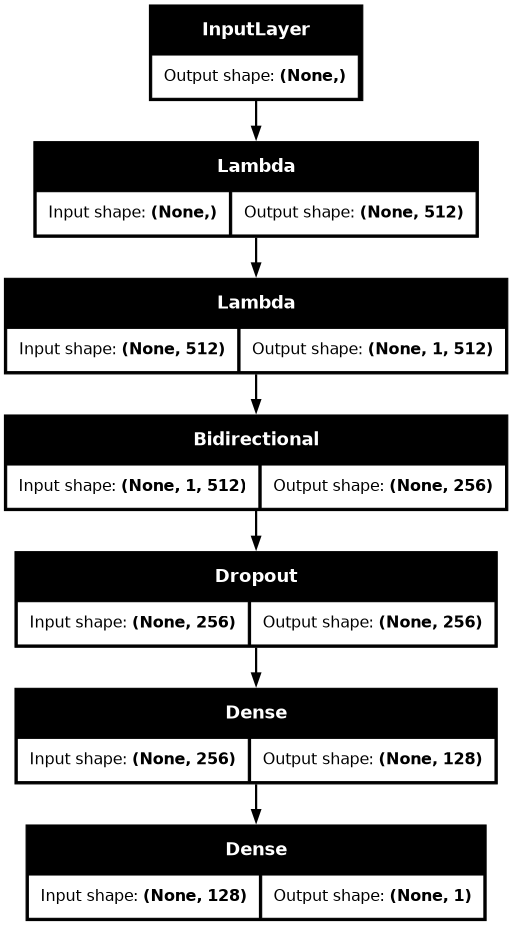

In [88]:
tf.keras.utils.plot_model(model, dpi = 80,
                         show_shapes = True,
                         expand_nested = True)

In [89]:
# function to train the model
def train_model(model, num_epochs, callbacks_list, train_data, train_target, valid_data = None, shuffling = False):
    model_history = {}
    
    if valid_data != None:
        model_history = model.fit(train_data,
                                  train_target,
                                  epochs = num_epochs,
                                  validation_data = valid_data,
                                  callbacks = callbacks_list,
                                  shuffle = shuffling)
    if valid_data == None:
        model_history = model.fit(train_data,
                                  train_target,
                                  epochs = num_epochs,
                                  callbacks = callbacks_list,
                                  shuffle = shuffling)
    return model_history

In [91]:
# define callbacks and metrics for training the model
checkpoint_path = "USE_Model.weights.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    save_best_only = True,
    save_weights_only = True,
    monitor = "val_accuracy",
    verbose = 1
)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss', 
    patience = 10, 
    restore_best_weights = True)

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_loss',
    patience = 3,
    factor = 0.5,
    verbose = 1, min_lr = 1e-6)

CALLBACKS = [early_stopping_callback, reduce_lr_callback, checkpoint_callback]
METRICS = ['accuracy']

In [92]:
# compile and train the USE Model
tf.random.set_seed(42)

model.compile(
    loss = 'binary_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    metrics = METRICS
)

model_history = train_model(
    model, 100, CALLBACKS, 
    train_data = train_sentences,
    train_target = train_labels,
    valid_data = (val_sentences, val_labels),
    shuffling = False
) 

Epoch 1/100
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7420 - loss: 0.5428
Epoch 1: val_accuracy improved from -inf to 0.81102, saving model to USE_Model.weights.h5
215/215 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.7422 - loss: 0.5424 - val_accuracy: 0.8110 - val_loss: 0.4294 - learning_rate: 0.0010
Epoch 2/100
211/215 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8127 - loss: 0.4229
Epoch 2: val_accuracy improved from 0.81102 to 0.81627, saving model to USE_Model.weights.h5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8129 - loss: 0.4225 - val_accuracy: 0.8163 - val_loss: 0.4220 - learning_rate: 0.0010
Epoch 3/100
214/215 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8190 - loss: 0.4103
Epoch 3: val_accuracy improved from 0.81627 to 0.81759, saving model to USE_Model.weights.h5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8191 - loss: 0.4102 - val_accuracy: 0.8176 - val_loss: 0.4209 - learning_rate: 0.0010
Epoch 4/100
211/215 ━━━━━━━━━━━━━

In [94]:
from helper_functions import calculate_results

# Evaluate the USE Model
model.load_weights("USE_Model.weights.h5")
model_4_pred_probs = model.predict(val_sentences)
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_results = calculate_results(y_true = val_labels,
                                    y_pred = model_4_preds)
model_4_results

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


{'accuracy': 82.28346456692913,
 'precision': 0.8276013025242611,
 'recall': 0.8228346456692913,
 'f1': 0.8207515552385499}

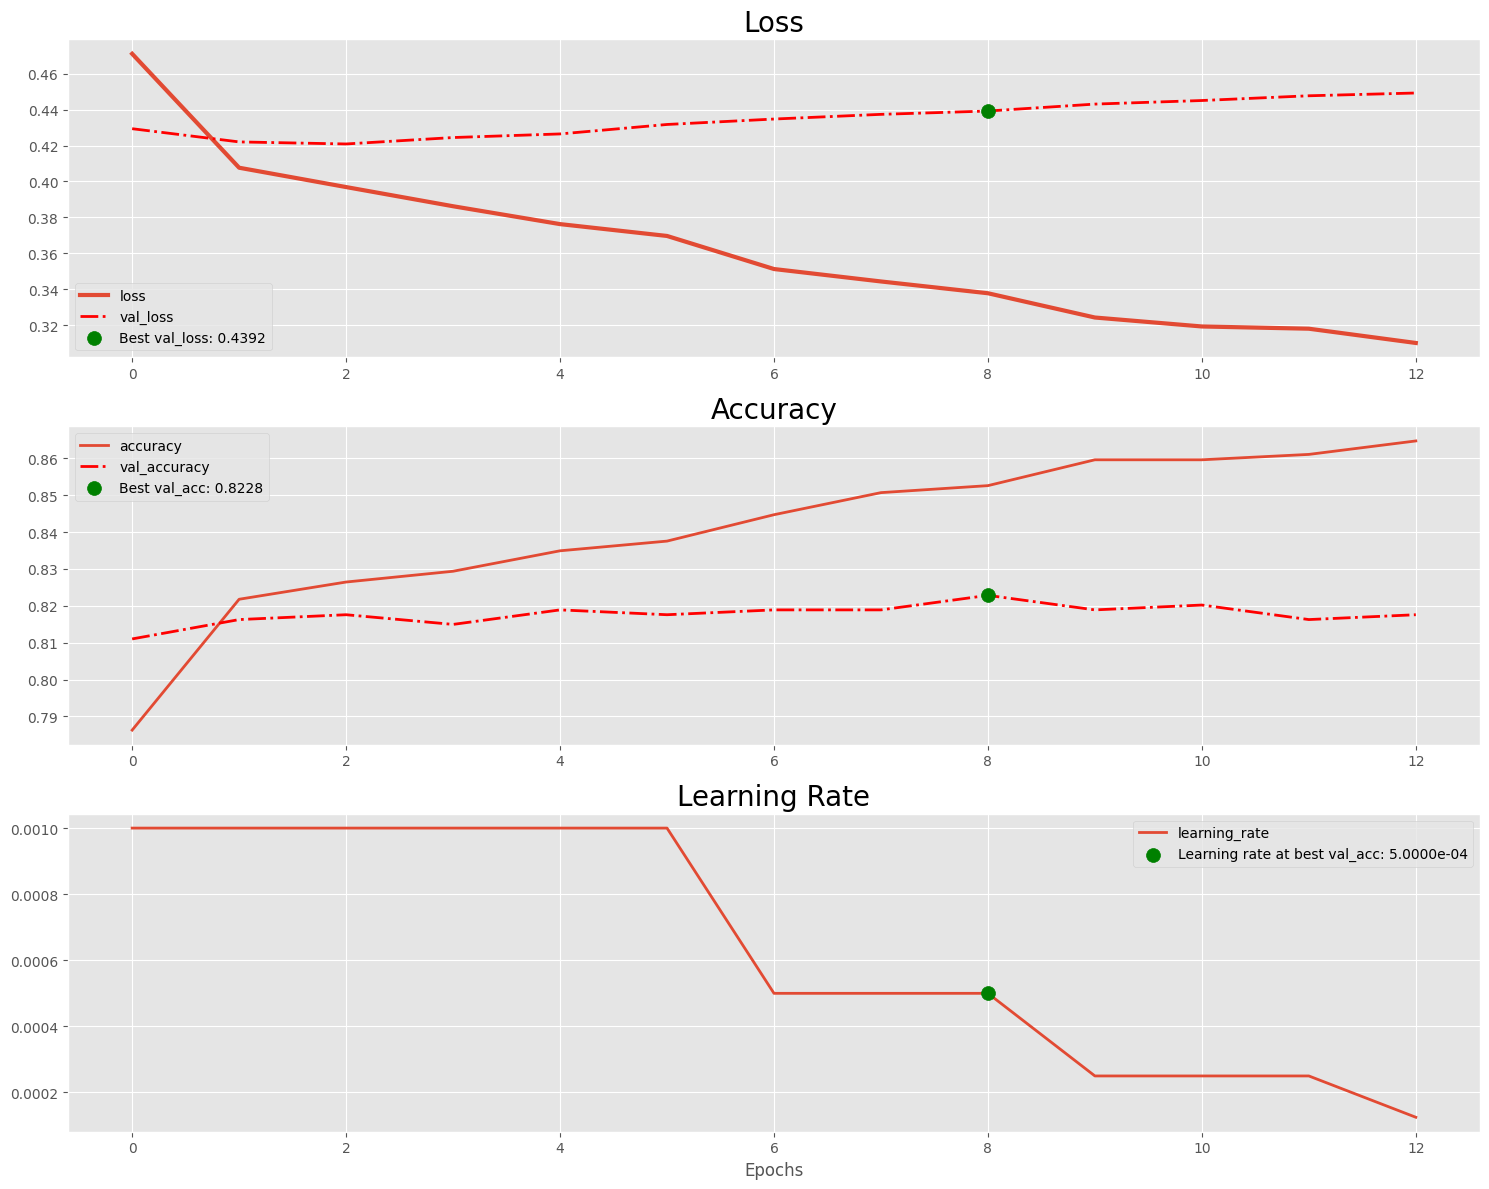

In [95]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Assuming model_history is already available and model_history.history is the training history

# Convert history to DataFrame
result_df = pd.DataFrame(model_history.history)
x = np.arange(len(result_df))

# Find the best epoch for validation accuracy
best_epoch = np.argmax(result_df['val_accuracy'])
best_val_acc = result_df.val_accuracy[best_epoch]
best_val_loss = result_df.val_loss[best_epoch]
best_accuracy = result_df.accuracy[best_epoch]
best_loss = result_df.loss[best_epoch]
best_learning_rate = result_df.learning_rate[best_epoch]

# Plotting
fig, ax = plt.subplots(3, 1, figsize=(15, 12))

# AX0: Loss
ax[0].plot(x, result_df.loss, label='loss', linewidth=3)
ax[0].plot(x, result_df.val_loss, label='val_loss', linewidth=2, ls='-.', c='r')
ax[0].scatter(best_epoch, best_val_loss, label=f'Best val_loss: {best_val_loss:.4f}', color='g', s=100, zorder=5)
ax[0].set_title('Loss', fontsize=20)
ax[0].legend()

# AX1: Accuracy
ax[1].plot(x, result_df.accuracy, label='accuracy', linewidth=2)
ax[1].plot(x, result_df.val_accuracy, label='val_accuracy', linewidth=2, ls='-.', c='r')
ax[1].scatter(best_epoch, best_val_acc, label=f'Best val_acc: {best_val_acc:.4f}', color='g', s=100, zorder=5)
ax[1].set_title('Accuracy', fontsize=20)
ax[1].legend()

# AX2: Learning rate
ax[2].plot(x, result_df.learning_rate, label='learning_rate', linewidth=2)
ax[2].scatter(best_epoch, best_learning_rate, label=f'Learning rate at best val_acc: {best_learning_rate:.4e}', color='g', s=100, zorder=5)
ax[2].set_title('Learning Rate', fontsize=20)
ax[2].set_xlabel('Epochs')
ax[2].legend()

# Share x-axis for all subplots
plt.tight_layout()
plt.show()

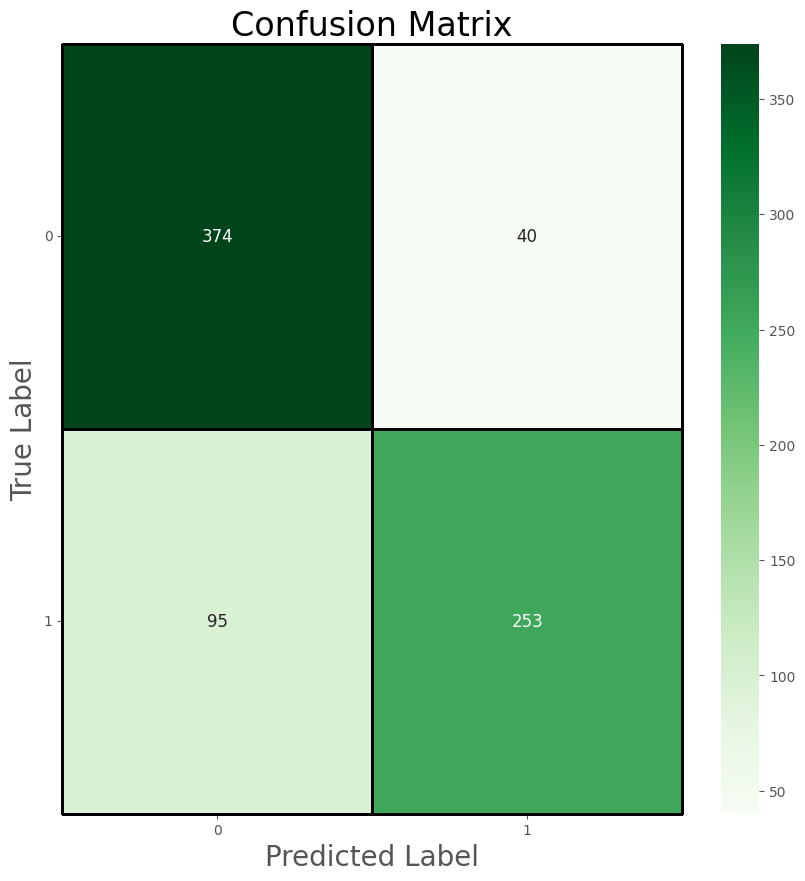

In [101]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, classes='auto', figsize=(10, 10), text_size=12): 
    # Generate confusion matrix 
    cm = confusion_matrix(y_true, y_pred)
    
    # Set plot size
    plt.figure(figsize=figsize)

    # Create confusion matrix heatmap
    disp = sns.heatmap(
        cm, annot=True, cmap='Greens',
        annot_kws={"size": text_size}, fmt='g',
        linewidths=1, linecolor='black', clip_on=False,
        xticklabels=classes, yticklabels=classes)
    
    # Set title and axis labels
    disp.set_title('Confusion Matrix', fontsize=24)
    disp.set_xlabel('Predicted Label', fontsize=20) 
    disp.set_ylabel('True Label', fontsize=20)
    plt.yticks(rotation=0) 

    # Plot confusion matrix
    plt.show()
    
    return

plot_confusion_matrix(
    val_labels, 
    model_4_preds, 
    figsize=(10, 10))

## <a id='step63'></a>
# <span style="font-family:Tahoma, sans-serif; font-size:110%; text-align:left;">
# <span style="color:#FF6347;"><b></b></span>
# <span style="color:#2E8B57;"><b>Generate Submission</b></span>
# </span>


In [103]:
def predict(model, test_tweets):
    probabilities = model.predict(test_tweets, verbose = 1)
    predictions = tf.argmax(probabilities, axis = 1)
    return probabilities, predictions
test_tweets = test['text']
test_tweets.shape

(3263,)

In [107]:
# Generate Test Predictions
test_probabilities, test_predictions = predict(model,
                                               tf.convert_to_tensor(test_tweets, dtype=tf.string))

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [108]:
test_predictions

<tf.Tensor: shape=(3263,), dtype=int64, numpy=array([0, 0, 0, ..., 0, 0, 0])>

In [111]:
sub = pd.DataFrame({'id':sample_sub['id'].values.tolist(), 'target':test_predictions})
sub.to_csv('submission.csv',index = False)

<font size='5' color='#FF4500'><b>✨ If you find this kernel helpful, I’d really appreciate your upvote! 😊 Your support encourages me to keep improving and sharing more content. 🙏✨</b></font>
